# Deep Learning and AI Project

The subject of this project is the classification of microscopy images using neural networks. Dataset contains histopathological images of lungs. All images are 768x768 pixels in size. There are three classes in the dataset: 

*   Lung benign tissue
*   Lung adenocarcinoma
*   Lung squamous cell carcinoma

In [ ]:
#install opendatasets package to download the dataset of interest directly from kaggle
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import necessary libraries for the whole process
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od
import os
import re
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
import seaborn as sns

import visualkeras

#tensorflow 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

In [ ]:
#function to plot the perfomance of the models
def plot_val_acc(history_ds, n_epochs = 10, title = ''):
  

  acc = history_ds.history['accuracy']
  val_acc = history_ds.history['val_accuracy']

  loss=history_ds.history['loss']
  val_loss=history_ds.history['val_loss']

  epochs_range = range(1,(n_epochs+1))

  plt.figure(figsize=(8,4))

  if title != '':
    plt.suptitle(title, fontsize=16)
  
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, loss, label='Training', marker = 'o', color = 'firebrick')
  plt.plot(epochs_range, val_loss, label='Validation', marker = 'o', color = 'steelblue')
  plt.legend(loc='upper right')
  plt.yticks (fontsize=10)
  plt.xticks ([*range(1,(n_epochs+1))], fontsize=10)
  plt.xlabel('epochs', fontdict = {'fontsize':10})
  plt.title('Loss', fontdict = {'fontsize':12})

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, acc, label='Training', marker = 'o', color = 'firebrick')
  plt.plot(epochs_range, val_acc, label='Validation',marker = 'o',  color = 'steelblue')
  plt.legend(loc='lower right')
  plt.yticks (fontsize=10)
  plt.xticks ([*range(1,(n_epochs+1))], fontsize=10)
  plt.xlabel('epochs', fontdict = {'fontsize':10})
  plt.title('Accuracy', fontdict = {'fontsize':12})

  plt.show()

## API Token

There is one important step in order to download the dataset from Kaggle Repository to Colab. You have to generate an API token which will be used from collab to access the dataset. This [video](https://www.youtube.com/watch?v=57N1g8k2Hwc&t=273s) is an excellent guide on how to do it. If you run this script locally, just put the token in same directory with the script

If you run the script locally don't use this part of code, comment it out with hashtags.

In [ ]:
#access will be requested to your driver to copy API token in this session
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/kaggle/kaggle.json' '/content'

Mounted at /content/drive


Download Dataset Directly From Kaggle\
Download will last about 30 second

In [ ]:
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

100%|██████████| 1.76G/1.76G [00:25<00:00, 73.3MB/s]


## Creation of Proper Directories

Each class in the original dataset contains 5000, that means 15000 in total. During experimentation the limits of memory were exceeded, so we had to drop 50% of dataset(2500 each class after drop) in order the process to run smoothly. 

Then train, validation and test directories were created. Train directory contains 60% of data, validation and test 20% each. 


In [ ]:
#path for histopathological images
lung_path = './lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

#delete unnecessary folders which are included in the initial dataset
shutil.rmtree('./lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/')

#process to drop a part of data and create proper directories
X = []
y = []

for i in os.listdir(lung_path):
    temp = lung_path+'/'+i
    for j in os.listdir(temp):
        X.append(j)
        word = re.findall(r'[a-z]+', j)[0]
        y.append(word)

#drop data
X_keep, X_drop, y_keep, y_drop = train_test_split(X,y, test_size=0.5, random_state = 0)

#train, test, validation data separation
X_train, X_test_val, y_train, y_test_val = train_test_split(X_keep, y_keep, test_size = 0.4, random_state = 0)
X_test, X_val, y_test, y_val  = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 0)

#creation of directories
for i in ['train', 'test', 'val']:
    os.mkdir(i)
    for j in set(y):
        temp_path = i+'/'+j
        os.mkdir(temp_path)

#load data to directories
for i in range(len(X_train)):
    folder = y_train[i][:4]+'_'+y_train[i][4:]
    src_path = os.path.join(lung_path, folder, X_train[i])
    dest_path = './train/'+y_train[i]+'/'
    shutil.copy(src_path,dest_path)

for i in range(len(X_test)):
    folder = y_test[i][:4]+'_'+y_test[i][4:]
    src_path = os.path.join(lung_path, folder, X_test[i])
    dest_path = './test/'+y_test[i]+'/'
    shutil.copy(src_path,dest_path)  

for i in range(len(X_val)):
    folder = y_val[i][:4]+'_'+y_val[i][4:]
    src_path = os.path.join(lung_path, folder, X_val[i])
    dest_path = './val/'+y_val[i]+'/'
    shutil.copy(src_path,dest_path) 

#keep only train, test, validation directories
shutil.rmtree('./lung-and-colon-cancer-histopathological-images')

## Preprocessing

In this step train, validation and test dataset, using keras library, are created. Images are resized to 224x224 and values of each image are rescaled between [0,1]. 

In [ ]:
#paths of directories
train_dir = './train/'
test_dir = './test/'
val_dir = './val/'

In [ ]:
#batch_size defines the number of samples to work before updating the internal model parameters
batch_size = 128
X = Y = 224 # shape of resizing

In [ ]:
#creation of datasets
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir
                                                      , image_size = (X,Y)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')
                                                      
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir
                                                    , image_size = (X,Y)
                                                    , batch_size = batch_size
                                                    , label_mode = 'categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir
                                                      , image_size = (X,Y)
                                                      , labels = 'inferred'
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')

Found 4500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [ ]:
#names of classes
class_names = np.array(train_ds.class_names)
print(class_names)

#number of classes
num_class = len(class_names)
print(f"The Classes are {num_class}!")

['lungaca' 'lungn' 'lungscc']
The Classes are 3!


In [ ]:
#rescaling values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Visualize the Data

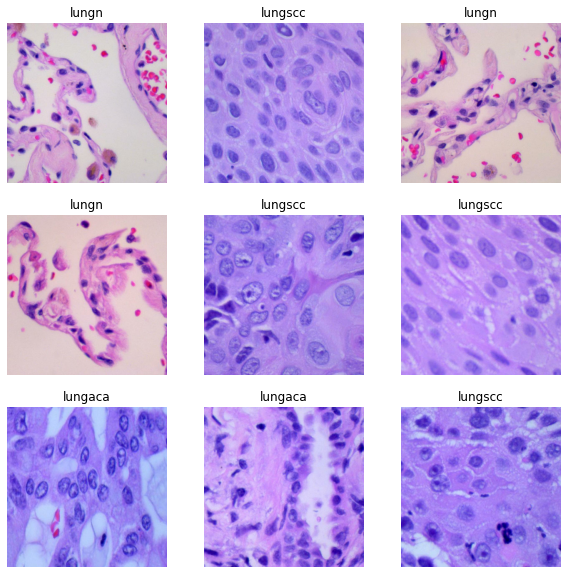

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[np.array(labels[i]).astype(bool)][0])
    plt.axis("off")

## Model Development

### First Attempt

The initial model consists of three convolutional blocks, each of them is followed by a MaxPool Layer. After feature extraction, flattening layer, a fully connected neural network is added, which consists of two layers with 128 and 64 nodes and relu as activation function. 

In [ ]:
#early stopping to prevent overfitting
early_callback = EarlyStopping(monitor='val_loss', patience = 5)

#keep the weights which gave the best resutls
checkpoint_callback = ModelCheckpoint('first_attempt_model_weights.hdf5', monitor = 'val_loss',
                                        save_best_only = True)

callbacks_list_first = [early_callback, checkpoint_callback]

####Model Structure of a Simple CNN model from scratch

In [ ]:
#model structure
simple_cnn = Sequential()
simple_cnn.add(Conv2D(32,kernel_size=3, activation= 'relu', padding = 'same', input_shape = (X,Y,3)))
simple_cnn.add(MaxPool2D())
simple_cnn.add(Conv2D(64,kernel_size=3, padding = 'same', activation= 'relu'))
simple_cnn.add(MaxPool2D())
simple_cnn.add(Conv2D(128,kernel_size=3, padding = 'same', activation= 'relu'))
simple_cnn.add(MaxPool2D())
simple_cnn.add(Flatten())
simple_cnn.add(Dense(128, activation='relu'))
simple_cnn.add(Dense(64, activation='relu'))
simple_cnn.add(Dense(num_class, activation = 'softmax'))

As optimizer Adam is chosen and as loss function, due to multiclass classification, categorical cross entropy is used. 

In [ ]:
simple_cnn.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )

In [ ]:
simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [ ]:
# fitting the model
n_epochs = 10

simple_cnn_history = simple_cnn.fit(train_ds,
                                epochs = n_epochs,
                                validation_data = val_ds,
                                callbacks = callbacks_list_first
                                )

Epoch 1/10
36/36 [==============================] - 23s 542ms/step - loss: 0.7321 - accuracy: 0.6764 - val_loss: 0.4484 - val_accuracy: 0.8393
Epoch 2/10
36/36 [==============================] - 19s 466ms/step - loss: 0.3465 - accuracy: 0.8547 - val_loss: 0.8492 - val_accuracy: 0.6887
Epoch 3/10
36/36 [==============================] - 18s 442ms/step - loss: 0.3239 - accuracy: 0.8720 - val_loss: 0.2580 - val_accuracy: 0.8873
Epoch 4/10
36/36 [==============================] - 19s 467ms/step - loss: 0.2316 - accuracy: 0.9036 - val_loss: 0.2379 - val_accuracy: 0.9027
Epoch 5/10
36/36 [==============================] - 18s 449ms/step - loss: 0.1916 - accuracy: 0.9184 - val_loss: 0.2849 - val_accuracy: 0.8800
Epoch 6/10
36/36 [==============================] - 22s 546ms/step - loss: 0.1580 - accuracy: 0.9389 - val_loss: 0.3008 - val_accuracy: 0.8853
Epoch 7/10
36/36 [==============================] - 18s 438ms/step - loss: 0.1279 - accuracy: 0.9500 - val_loss: 0.2397 - val_accuracy: 0.9187

Our Model is overfitting

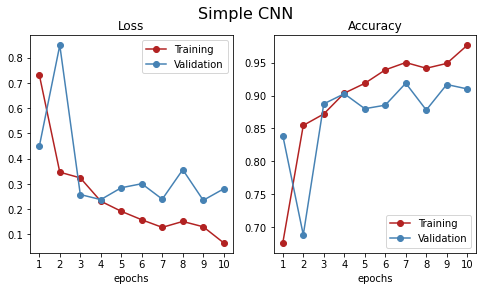

In [ ]:
plot_val_acc(simple_cnn_history, n_epochs = n_epochs, title = 'Simple CNN')

In [ ]:
simple_cnn.load_weights('first_attempt_model_weights.hdf5')
simple_cnn.evaluate(test_ds)

12/12 [==============================] - 4s 155ms/step - loss: 0.2417 - accuracy: 0.9160


[0.24174392223358154, 0.9160000085830688]

### Reduce Overfitting with Augmentation and Dropout Reguralization Technique

Only Train Dataset was increased. Images rotated until 10 degrees and flipped horizontally and vertically

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=10,  
                    horizontal_flip=True,
                    vertical_flip = True,
                    )

In [ ]:
train_ds = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(X, Y),
                                                     class_mode='categorical')

Found 4500 images belonging to 3 classes.


In [ ]:
#creation of validation and test set                                                    
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir
                                                    , image_size = (X,Y)
                                                    , batch_size = batch_size
                                                    , label_mode = 'categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir
                                                      , image_size = (X,Y)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')

Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [ ]:
#rescaling values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

###Dropout

Also Dropout Layers were added after Pooling Layes. This is also an action to prevent overfitting.

In [ ]:
#keep the weights which gave the best resutls
checkpoint_callback_dropout = ModelCheckpoint('dropout_model.hdf5', monitor = 'val_loss',
                                        save_best_only = True)

callbacks_dropout = [checkpoint_callback_dropout]

In [ ]:
#models with dropout structure
simple_cnn_dropout = Sequential()
simple_cnn_dropout.add(Conv2D(32,kernel_size=3, activation= 'relu', padding = 'same', input_shape = (X,Y,3)))
simple_cnn_dropout.add(MaxPool2D())
simple_cnn_dropout.add(Dropout(0.25))
simple_cnn_dropout.add(Conv2D(64,kernel_size=3, padding = 'same', activation= 'relu'))
simple_cnn_dropout.add(MaxPool2D())
simple_cnn_dropout.add(Dropout(0.25))
simple_cnn_dropout.add(Conv2D(128,kernel_size=3, padding = 'same', activation= 'relu'))
simple_cnn_dropout.add(MaxPool2D())
simple_cnn_dropout.add(Dropout(0.25))
simple_cnn_dropout.add(Flatten())
simple_cnn_dropout.add(Dense(128, activation='relu'))
simple_cnn_dropout.add(Dense(64, activation='relu'))
simple_cnn_dropout.add(Dense(num_class, activation = 'softmax'))

In [ ]:
simple_cnn_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)       

In [ ]:
simple_cnn_dropout.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )

In [ ]:
# fitting the model
n_epochs = 10

simple_cnn_dropout_history = simple_cnn_dropout.fit(train_ds,
                                epochs = n_epochs,
                                validation_data = val_ds,
                                callbacks = callbacks_dropout
                                )

Epoch 1/10
36/36 [==============================] - 19s 455ms/step - loss: 1.5050 - accuracy: 0.5247 - val_loss: 0.8686 - val_accuracy: 0.5387
Epoch 2/10
36/36 [==============================] - 21s 514ms/step - loss: 0.5175 - accuracy: 0.7229 - val_loss: 0.5354 - val_accuracy: 0.7513
Epoch 3/10
36/36 [==============================] - 20s 479ms/step - loss: 0.4259 - accuracy: 0.7953 - val_loss: 0.4180 - val_accuracy: 0.8673
Epoch 4/10
36/36 [==============================] - 19s 473ms/step - loss: 0.3403 - accuracy: 0.8551 - val_loss: 0.4928 - val_accuracy: 0.7940
Epoch 5/10
36/36 [==============================] - 19s 462ms/step - loss: 0.2927 - accuracy: 0.8838 - val_loss: 0.3047 - val_accuracy: 0.8907
Epoch 6/10
36/36 [==============================] - 19s 454ms/step - loss: 0.2404 - accuracy: 0.8962 - val_loss: 0.3285 - val_accuracy: 0.8747
Epoch 7/10
36/36 [==============================] - 20s 483ms/step - loss: 0.2153 - accuracy: 0.9133 - val_loss: 0.3244 - val_accuracy: 0.8813

As plot shows, overfitting has vanished and the performance in train and validation set has no big difference

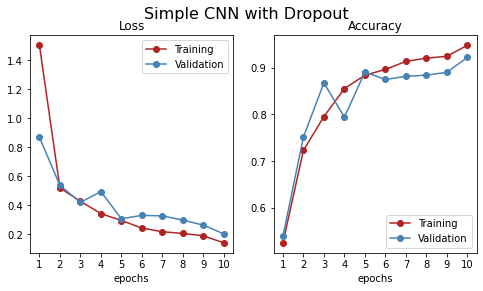

In [ ]:
#plot models perfomance in each epoch
plot_val_acc(simple_cnn_dropout_history, n_epochs = n_epochs, title = 'Simple CNN with Dropout')

In [ ]:
simple_cnn_dropout.load_weights('dropout_model.hdf5')
simple_cnn_dropout.evaluate(test_ds)

12/12 [==============================] - 5s 158ms/step - loss: 0.2053 - accuracy: 0.9307


[0.20534737408161163, 0.9306666851043701]

##Transfer Learning

In this section we use Pre-Trained models with tensorflow_hub. Weights of models are set non-trainable. A dense lays is added on the top of the model, appropriate for the current problem. 

In [ ]:
#batch_size defines the number of samples to work before updating the internal model parameters
batch_size = 16
X = Y = 224 # shape of resizing

#creation of datasets
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir
                                                      , image_size = (X,Y)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')
                                                      
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir
                                                    , image_size = (X,Y)
                                                    , batch_size = batch_size
                                                    , label_mode = 'categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir
                                                      , image_size = (X,Y)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')

#rescaling values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


###MobileNet_V2

In [ ]:
#keep the weights which gave the best resutls
checkpoint_callback_mobile = ModelCheckpoint('mobile_weights.hdf5', monitor = 'val_loss',
                                        save_best_only = True)

callbacks_mobile = [checkpoint_callback_mobile]

In [ ]:
mobile_net_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280],
                   trainable=False),  
    tf.keras.layers.Dense(num_class, activation='softmax')
])
mobile_net_model.build([None, 224, 224, 3])

In [ ]:
mobile_net_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobile_net_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
n_epochs = 10

history_mbn = mobile_net_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=n_epochs,
                    callbacks = callbacks_mobile
                    )

Epoch 1/10
282/282 [==============================] - 23s 68ms/step - loss: 0.1940 - accuracy: 0.9240 - val_loss: 0.1032 - val_accuracy: 0.9593
Epoch 2/10
282/282 [==============================] - 18s 63ms/step - loss: 0.0984 - accuracy: 0.9633 - val_loss: 0.0816 - val_accuracy: 0.9733
Epoch 3/10
282/282 [==============================] - 18s 61ms/step - loss: 0.0770 - accuracy: 0.9707 - val_loss: 0.0744 - val_accuracy: 0.9740
Epoch 4/10
282/282 [==============================] - 19s 66ms/step - loss: 0.0653 - accuracy: 0.9767 - val_loss: 0.0705 - val_accuracy: 0.9747
Epoch 5/10
282/282 [==============================] - 18s 61ms/step - loss: 0.0514 - accuracy: 0.9840 - val_loss: 0.0581 - val_accuracy: 0.9787
Epoch 6/10
282/282 [==============================] - 17s 61ms/step - loss: 0.0459 - accuracy: 0.9862 - val_loss: 0.0607 - val_accuracy: 0.9760
Epoch 7/10
282/282 [==============================] - 19s 67ms/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 0.0558 - val_accuracy:

In [ ]:
#mdel evaluation
mobile_net_model.evaluate(test_ds)

94/94 [==============================] - 5s 45ms/step - loss: 0.0570 - accuracy: 0.9800


[0.057045210152864456, 0.9800000190734863]

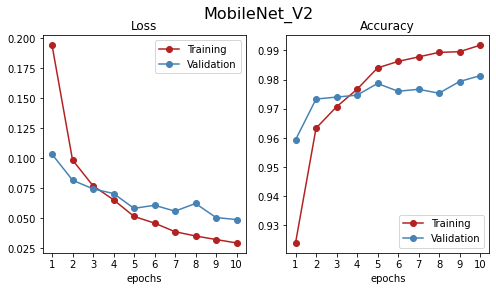

In [ ]:
#plot model's perfomance in each epoch
plot_val_acc(history_mbn, n_epochs = n_epochs, title = 'MobileNet_V2')

###ResNet50

In [ ]:
#keep the weights which gave the best resutls
checkpoint_callback_resnet = ModelCheckpoint('resnet50.hdf5', monitor = 'val_loss',
                                        save_best_only = True)

callbacks_resnet = [checkpoint_callback_resnet]

In [ ]:
#set model to non-trainable and add a dense output layer with 3 nodes
resnet50 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_class, activation='softmax')
])
resnet50.build([None, 224, 224, 3])

In [ ]:
resnet50.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dense_7 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,567,299
Trainable params: 6,147
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
resnet50.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
n_epochs = 10

history_resnet = resnet50.fit(train_ds,
                    validation_data=val_ds,
                    epochs=n_epochs,
                    callbacks = callbacks_resnet
                    )

Epoch 1/10
36/36 [==============================] - 44s 674ms/step - loss: 0.3644 - accuracy: 0.8567 - val_loss: 0.1536 - val_accuracy: 0.9447
Epoch 2/10
36/36 [==============================] - 23s 572ms/step - loss: 0.1403 - accuracy: 0.9471 - val_loss: 0.1303 - val_accuracy: 0.9487
Epoch 3/10
36/36 [==============================] - 23s 579ms/step - loss: 0.1183 - accuracy: 0.9564 - val_loss: 0.1108 - val_accuracy: 0.9560
Epoch 4/10
36/36 [==============================] - 24s 590ms/step - loss: 0.1056 - accuracy: 0.9618 - val_loss: 0.1015 - val_accuracy: 0.9580
Epoch 5/10
36/36 [==============================] - 26s 659ms/step - loss: 0.0941 - accuracy: 0.9651 - val_loss: 0.0954 - val_accuracy: 0.9607
Epoch 6/10
36/36 [==============================] - 24s 601ms/step - loss: 0.0870 - accuracy: 0.9662 - val_loss: 0.0925 - val_accuracy: 0.9620
Epoch 7/10
36/36 [==============================] - 26s 661ms/step - loss: 0.0823 - accuracy: 0.9696 - val_loss: 0.0859 - val_accuracy: 0.9620

In [ ]:
#model evaluation
resnet50.evaluate(test_ds)

94/94 [==============================] - 6s 58ms/step - loss: 0.0524 - accuracy: 0.9800


[0.05240500718355179, 0.9800000190734863]

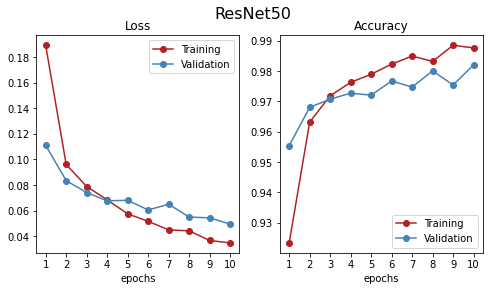

In [ ]:
#plot model's perfomance in each epoch
plot_val_acc(history_resnet, n_epochs = n_epochs, title = 'ResNet50')

##EfficientNet B7

In [ ]:
#keep the weights which gave the best resutls
checkpoint_callback_effnet7 = ModelCheckpoint('effnet7.hdf5', monitor = 'val_loss',
                                        save_best_only = True)

callbacks_effnet = [checkpoint_callback_effnet7]

In [ ]:
#set model to non-trainable and add a dense output layer with 3 nodes
effNet_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_class, activation='softmax')
])

effNet_model.build([None, 224, 224, 3])

In [ ]:
effNet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2560)              64097680  
                                                                 
 dense_8 (Dense)             (None, 3)                 7683      
                                                                 
Total params: 64,105,363
Trainable params: 7,683
Non-trainable params: 64,097,680
_________________________________________________________________


In [ ]:
effNet_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
n_epochs = 10

history_effNet = effNet_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=n_epochs,
                    callbacks = [callbacks_effnet]
                    )

Epoch 1/10
282/282 [==============================] - 110s 291ms/step - loss: 0.2448 - accuracy: 0.9107 - val_loss: 0.1472 - val_accuracy: 0.9480
Epoch 2/10
282/282 [==============================] - 77s 272ms/step - loss: 0.1272 - accuracy: 0.9571 - val_loss: 0.1123 - val_accuracy: 0.9613
Epoch 3/10
282/282 [==============================] - 77s 273ms/step - loss: 0.0960 - accuracy: 0.9678 - val_loss: 0.0992 - val_accuracy: 0.9627
Epoch 4/10
282/282 [==============================] - 77s 272ms/step - loss: 0.0806 - accuracy: 0.9751 - val_loss: 0.0868 - val_accuracy: 0.9673
Epoch 5/10
282/282 [==============================] - 77s 272ms/step - loss: 0.0700 - accuracy: 0.9789 - val_loss: 0.0809 - val_accuracy: 0.9700
Epoch 6/10
282/282 [==============================] - 77s 271ms/step - loss: 0.0625 - accuracy: 0.9798 - val_loss: 0.0752 - val_accuracy: 0.9720
Epoch 7/10
282/282 [==============================] - 77s 274ms/step - loss: 0.0565 - accuracy: 0.9822 - val_loss: 0.0711 - val_a

In [ ]:
#model evaluation
effNet_model.evaluate(test_ds)

94/94 [==============================] - 19s 199ms/step - loss: 0.0877 - accuracy: 0.9647


[0.08774081617593765, 0.9646666646003723]

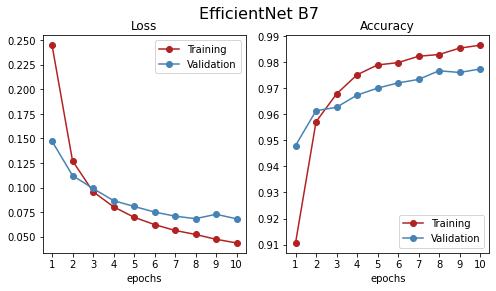

In [ ]:
#plot model's perfomance in each epoch
plot_val_acc(history_effNet, n_epochs = n_epochs, title = 'EfficientNet B7')

###Inception V3

Inception V3 as input gets images with shape 299x299, so we have to resize our images again.

In [ ]:
#batch_size defines the number of samples to work before updating the internal model parameters
batch_size = 16
X2 = Y2 = 299 # shape of resizing

#creation of datasets
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir
                                                      , image_size = (X2,Y2)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')
                                                      
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir
                                                    , image_size = (X2,Y2)
                                                    , batch_size = batch_size
                                                    , label_mode = 'categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir
                                                      , image_size = (X2,Y2)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')

#rescaling values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [ ]:
#keep the weights which gave the best resutls
checkpoint_callback_inceptv3 = ModelCheckpoint('inceptv3.hdf5', monitor = 'val_loss',
                                        save_best_only = True)

callbacks_inception = [checkpoint_callback_inceptv3]

In [ ]:
#set model to non-trainable and add a dense output layer with 3 nodes
inception_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5", output_shape=[2048],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_class, activation='softmax')
])
inception_model.build([None, 299, 299, 3]) 

In [ ]:
inception_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_9 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inception_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                    )

In [ ]:
n_epochs = 10

history_inception = inception_model.fit(train_ds,
                              validation_data=val_ds,
                              epochs=n_epochs,
                              callbacks = callbacks_inception
                              )

Epoch 1/10
282/282 [==============================] - 37s 109ms/step - loss: 0.2135 - accuracy: 0.9229 - val_loss: 0.1178 - val_accuracy: 0.9627
Epoch 2/10
282/282 [==============================] - 28s 98ms/step - loss: 0.1197 - accuracy: 0.9567 - val_loss: 0.0972 - val_accuracy: 0.9673
Epoch 3/10
282/282 [==============================] - 28s 99ms/step - loss: 0.0996 - accuracy: 0.9580 - val_loss: 0.0954 - val_accuracy: 0.9627
Epoch 4/10
282/282 [==============================] - 28s 97ms/step - loss: 0.0904 - accuracy: 0.9653 - val_loss: 0.0959 - val_accuracy: 0.9640
Epoch 5/10
282/282 [==============================] - 28s 98ms/step - loss: 0.0737 - accuracy: 0.9718 - val_loss: 0.0756 - val_accuracy: 0.9707
Epoch 6/10
282/282 [==============================] - 28s 97ms/step - loss: 0.0670 - accuracy: 0.9749 - val_loss: 0.0817 - val_accuracy: 0.9693
Epoch 7/10
282/282 [==============================] - 28s 98ms/step - loss: 0.0597 - accuracy: 0.9787 - val_loss: 0.0736 - val_accuracy

In [ ]:
#model evaluation
inception_model.evaluate(test_ds)

94/94 [==============================] - 9s 87ms/step - loss: 0.0702 - accuracy: 0.9740


[0.07018188387155533, 0.9739999771118164]

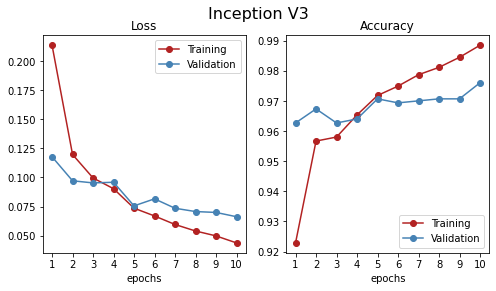

In [ ]:
#plot model's perfomance in each epoch
plot_val_acc(history_inception, n_epochs = n_epochs, title = 'Inception V3')

The chosen model is ResNet50, because it had the best accuracy score in the test set and the lowest value in the loss function. 

##Confusion Matrix for ResNet50

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(resnet50.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
cm = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
df_cm = pd.DataFrame({'Adenocarcinoma': cm[:,0], "Benign": cm[:,1], 'Squamus Cell Cancer': cm[:,2]}, index = ['Adenocarcinoma', 'Benign', 'Squamus Cell Cancer'])

In [ ]:
df_cm

,Adenocarcinoma,Benign,Squamus Cell Cancer
Adenocarcinoma,503,0,19
Benign,0,473,0
Squamus Cell Cancer,26,0,479


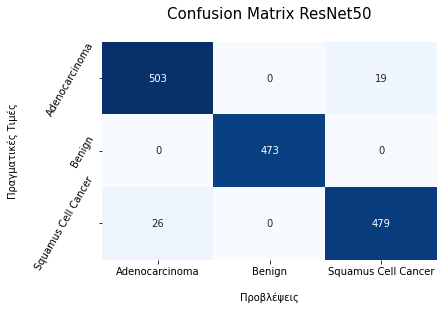

In [ ]:
ax = sns.heatmap(df_cm, annot=True, cmap='Blues', cbar = False, fmt = 'd')

ax.set_title('Confusion Matrix ResNet50\n', fontsize = 15);
ax.set_xlabel('\nΠροβλέψεις')
ax.set_ylabel('Πραγματικές Τιμές\n');
ax.set_yticklabels(df_cm.index, rotation=60)

## Display the visualization of the Confusion Matrix.
plt.show()

Model seems to classify 100% right if a patient has cancer or if he is healthy. But in the cancer classes, there are cases with wrong predictions about the cancer type